In [1]:
import pandas as pd
from modules import Agent,Model
from DCAStrategy import DCAAgent
from LSStrategy import LSSAgent
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


Start Trading

In [5]:
symbol = "MWG"
from_date ="2023-05-18"
to_date = "2024-06-18"

In [6]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [7]:
df.tail

<bound method NDFrame.tail of             Date    Close     Open     High      Low
0     2014-07-15   4718.0   4718.0   4718.0   4718.0
1     2014-07-16   5044.0   5044.0   5044.0   5044.0
2     2014-07-17   5396.0   5396.0   5396.0   5396.0
3     2014-07-18   5749.0   5749.0   5749.0   5749.0
4     2014-07-21   5749.0   6128.0   6128.0   5478.0
...          ...      ...      ...      ...      ...
2474  2024-06-12  63400.0  62600.0  63900.0  62000.0
2475  2024-06-13  64000.0  63700.0  64400.0  63100.0
2476  2024-06-14  63000.0  64000.0  64200.0  63000.0
2477  2024-06-17  62000.0  62800.0  62800.0  61000.0
2478  2024-06-18  62200.0  62100.0  62500.0  61100.0

[2479 rows x 5 columns]>

Trade without LSTM

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0.00000000e+000 1.00000000e+000 5.00754994e-150]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[2.57535202e-61 0.00000000e+00 1.00000000e+00]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[

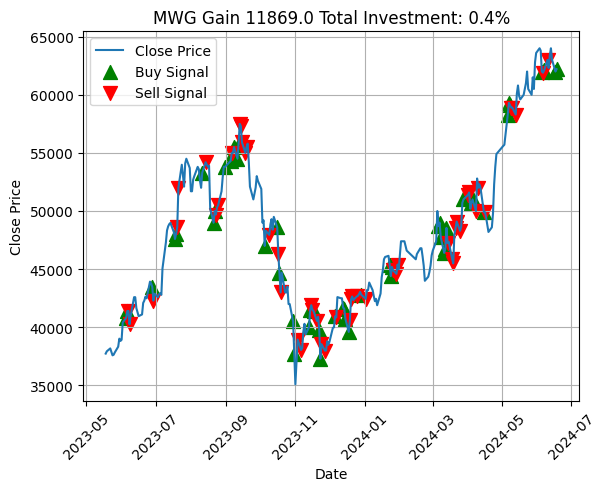

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 3000000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [21]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [22]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0.00000000e+00 1.00000000e+00 1.05639477e-97]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1.58828161e-109 0.00000000e+000 1.00000000e+000]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[

In [23]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [24]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

0.5061243217703818
0.4023
11869.000000000015
0.39563333333333384


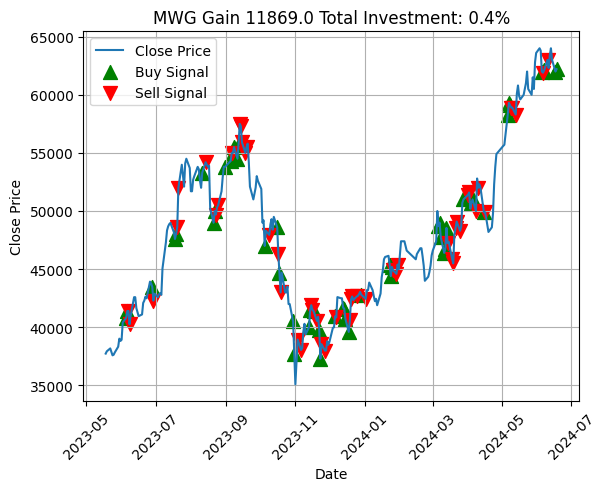

In [25]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

With LSTM

In [ ]:
# df = pd.read_csv(f'DataTraining/{symbol}.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df_init = df[['Close']]  
# df_init = data_preprocessing(df_init, Feature_Extractor)
# real_trend = df_init['Close'].tolist()
# parameters = [df_init[cl].tolist() for cl in df_init.columns]
# # initial_money = np.max(parameters[0]) * 3
# initial_money = 500000
# minmax = pickle.load(open(f"checkpoint/{symbol}prediction_scaler.pkl", 'rb'))
# scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
# with open(f"checkpoint/{symbol}prediction_model.pkl", 'rb') as fopen:
#     model = pickle.load(fopen)
# df = df[['Date', 'Close']]
# #Preprocess Dataframe
# df = data_preprocessing(df, Feature_Extractor)
# selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
# data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# agent2 = Agent(model = model,
#                 timeseries = scaled_parameters,
#                 skip = skip,
#                 initial_money = initial_money,
#                 real_trend = real_trend,
#                 minmax = minmax,
#                 window_size = 10)

In [ ]:
# trade_results = []
# for row in data_list:
#     #ensure first column is Date
#     date = row[0]
#     value = row[1:]
#     result = agent2.trade(value, date = date)
#     trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0.00000000e+000 1.00000000e+000 2.30880285e-259]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]


In [ ]:
# result = pd.DataFrame(trade_results)

# # Convert the 'date' column to datetime format
# result['date'] = pd.to_datetime(result['date'])
# # total_gain = result['gain'].sum()
# # total_investment = result['investment'].sum()

In [ ]:
# df_action_2 = result[result['action'] == 2]

# # Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
# df_action_2_sorted = df_action_2.sort_values(by='date')

# # Lấy giá trị total_investment của hàng cuối cùng
# last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
# df_sorted = result.sort_values(by='date')

# # Lấy giá trị total của hàng cuối cùng
# last_total = df_sorted.iloc[-1]['total']
# investmentvalue = (last_total-initial_money)/initial_money *100
# total_gain = result['gain'].sum()
# investGain = total_gain/initial_money *100

1.7851012701682114
0.52
2600.0
0.52


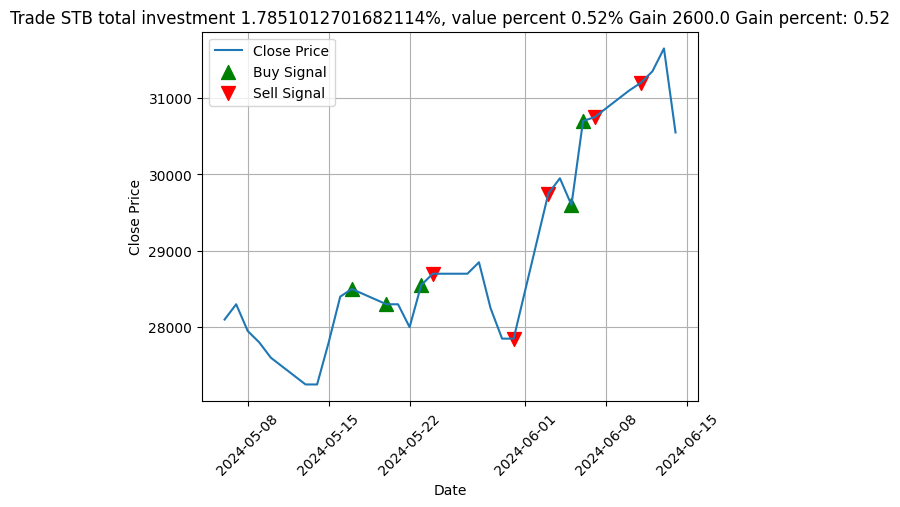

In [ ]:
# print(last_total_investment)
# print(investmentvalue)
# print(total_gain)
# print(investGain)

# # Mark buy and sell actions
# buy_signals = result[result['action'] == 1]
# sell_signals = result[result['action'] == 2]
# plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

# plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
# plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# # Customize the plot
# plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()

DCA without LSTM

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0.00000000e+00 1.00000000e+00 1.36433632e-39]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 

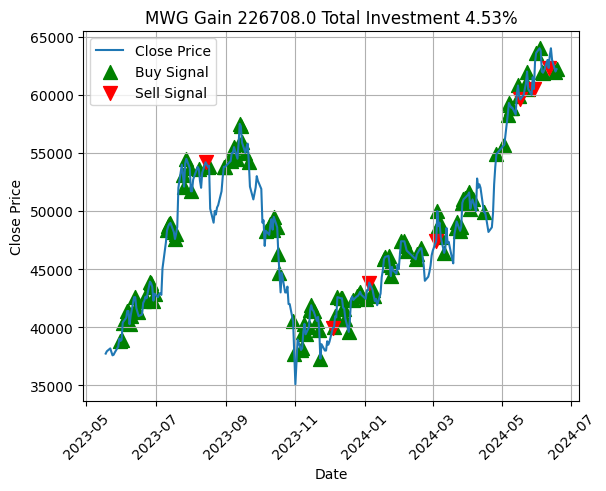

In [35]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = np.max(parameters[0]) * 5
initial_money =  5000000
minmax = pickle.load(open(f"checkpoint/{symbol}_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

agent3 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent3.trade(value, date = date)
    trade_results.append(result)

result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

In [ ]:
# df = pd.read_csv(f'DataTraining/{symbol}.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df_init = df[['Close']]  
# df_init = data_preprocessing(df_init, Feature_Extractor)
# real_trend = df_init['Close'].tolist()
# parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = 500000
# minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_DCAscaler.pkl", 'rb'))
# scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
# with open(f"checkpoint/{symbol}Prediction_DCAmodel.pkl", 'rb') as fopen:
#     model = pickle.load(fopen)
# df = df[['Date', 'Close']]
# #Preprocess Dataframe
# df = data_preprocessing(df, Feature_Extractor)
# selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
# data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# agent4 = DCAAgent(model = model,
#                 timeseries = scaled_parameters,
#                 skip = skip,
#                 initial_money = initial_money,
#                 real_trend = real_trend,
#                 minmax = minmax,
#                 window_size = 10)

In [ ]:
# trade_results = []
# for row in data_list:
#     #ensure first column is Date
#     date = row[0]
#     value = row[1:]
#     result = agent4.trade(value, date = date)
#     trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


In [ ]:
# result = pd.DataFrame(trade_results)

# # Convert the 'date' column to datetime format
# result['date'] = pd.to_datetime(result['date'])
# # total_gain = result['gain'].sum()
# # total_investment = result['investment'].sum()

In [ ]:
# df_action_2 = result[result['action'] == 2]

# # Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
# df_action_2_sorted = df_action_2.sort_values(by='date')

# # Lấy giá trị total_investment của hàng cuối cùng
# last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
# df_sorted = result.sort_values(by='date')

# # Lấy giá trị total của hàng cuối cùng
# last_total = df_sorted.iloc[-1]['total']
# investmentvalue = (last_total-initial_money)/initial_money *100
# total_gain = result['gain'].sum()
# investGain = total_gain/initial_money *100

IndexError: single positional indexer is out-of-bounds

In [ ]:
# print(last_total_investment)
# print(investmentvalue)
# print(total_gain)
# print(investGain)

# # Mark buy and sell actions
# buy_signals = result[result['action'] == 1]
# sell_signals = result[result['action'] == 2]
# plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

# plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
# plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# # Customize the plot
# plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()

NameError: name 'last_total_investment' is not defined

LSS WITHOUT LSTM


In [13]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 10000000
minmax = pickle.load(open(f"checkpoint/{symbol}_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()


In [14]:
agent5 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [15]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent5.trade(value, date = date)
    trade_results.append(result)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1.00000000e+000 1.14247961e-100 0.00000000e+000]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1.60071718e-222 1.00000000e+000 0.00000000e+000]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[3.69616167e-210 1.00000000e+000 0.00000000e+000]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0.

In [16]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [17]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 70541.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.818127',
  'date': '2023-05-18'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 70456.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.818127',
  'date': '2023-05-19'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 70201.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.819126',
  'date': '2023-05-22'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 69776.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.819126',
  'date': '2023-05-23'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 69180.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.819126',
  'date': '2023-05-24'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 70797.0,
  'balance': 10000000,
  'timestamp': '2024-06-24 23:41:06.819126',
  'date': '2023-0

In [18]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

3.095145084812352
27.92022
3579221.9999999963
35.792219999999965


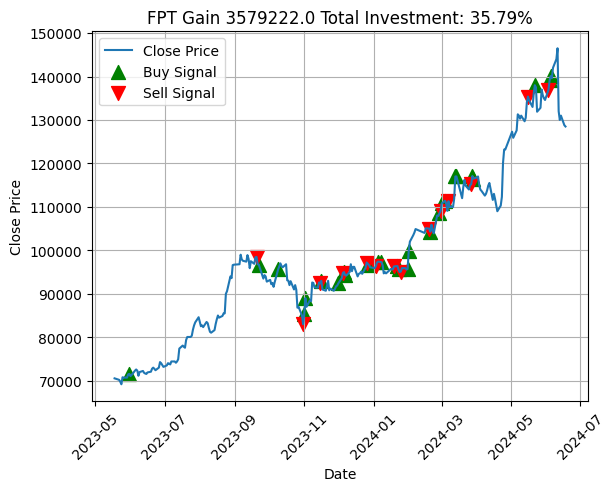

In [19]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITH LSTM

In [ ]:
# df = pd.read_csv(f'DataTraining/{symbol}.csv')
# df['Date'] = pd.to_datetime(df['Date'])
# df_init = df[['Close']]  
# df_init = data_preprocessing(df_init, Feature_Extractor)
# real_trend = df_init['Close'].tolist()
# parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = 500000
# minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_LSSscaler.pkl", 'rb'))
# scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
# with open(f"checkpoint/{symbol}Prediction_LSSmodel.pkl", 'rb') as fopen:
#     model = pickle.load(fopen)
# df = df[['Date', 'Close']]
# #Preprocess Dataframe
# df = data_preprocessing(df, Feature_Extractor)
# selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
# data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# agent6 = LSSAgent(model = model,
#                 timeseries = scaled_parameters,
#                 skip = skip,
#                 initial_money = initial_money,
#                 real_trend = real_trend,
#                 minmax = minmax,
#                 window_size = 10)

In [ ]:
# trade_results = []
# for row in data_list:
#     #ensure first column is Date
#     date = row[0]
#     value = row[1:]
#     result = agent6.trade(value, date = date)
#     trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [ ]:
# result = pd.DataFrame(trade_results)

# # Convert the 'date' column to datetime format
# result['date'] = pd.to_datetime(result['date'])
# # total_gain = result['gain'].sum()
# # total_investment = result['investment'].sum()

In [ ]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,gain
0,data not enough to trade,0,28100.0,500000.0,2024-06-18 20:46:05.795261,2024-05-06,NaN,NaN,NaN,NaN
1,data not enough to trade,0,28300.0,500000.0,2024-06-18 20:46:05.795261,2024-05-07,NaN,NaN,NaN,NaN
2,data not enough to trade,0,27950.0,500000.0,2024-06-18 20:46:05.795261,2024-05-08,NaN,NaN,NaN,NaN
3,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:46:05.795261,2024-05-09,NaN,NaN,NaN,NaN
4,data not enough to trade,0,27600.0,500000.0,2024-06-18 20:46:05.795261,2024-05-10,NaN,NaN,NaN,NaN
5,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:46:05.796405,2024-05-13,NaN,NaN,NaN,NaN
6,data not enough to trade,0,27250.0,500000.0,2024-06-18 20:46:05.796405,2024-05-14,NaN,NaN,NaN,NaN
7,data not enough to trade,0,27800.0,500000.0,2024-06-18 20:46:05.796405,2024-05-15,NaN,NaN,NaN,NaN
8,data not enough to trade,0,28400.0,500000.0,2024-06-18 20:46:05.796405,2024-05-16,NaN,NaN,NaN,NaN
9,do nothing,0,28500.0,500000.0,2024-06-18 20:46:05.797809,2024-05-17,500000.0,NaN,NaN,NaN


In [ ]:
# df_action_2 = result[result['action'] == 2]

# # Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
# df_action_2_sorted = df_action_2.sort_values(by='date')

# # Lấy giá trị total_investment của hàng cuối cùng
# last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
# df_sorted = result.sort_values(by='date')

# # Lấy giá trị total của hàng cuối cùng
# last_total = df_sorted.iloc[-1]['total']
# investmentvalue = (last_total-initial_money)/initial_money *100
# total_gain = result['gain'].sum()
# investGain = total_gain/initial_money *100

7.867310625317743
7.140000000000001
30950.0
6.1899999999999995


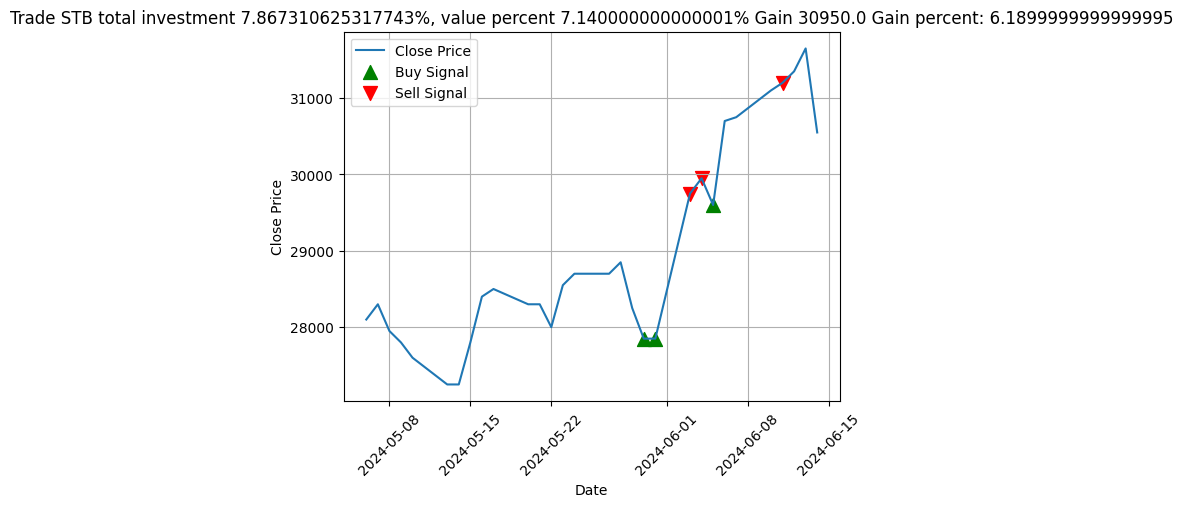

In [ ]:
# print(last_total_investment)
# print(investmentvalue)
# print(total_gain)
# print(investGain)

# # Mark buy and sell actions
# buy_signals = result[result['action'] == 1]
# sell_signals = result[result['action'] == 2]
# plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

# plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
# plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# # Customize the plot
# plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()